In [25]:
import getpass
user_id = getpass.getuser()

import sys
sys.path.append(f"/home/{user_id}/OTTEHR/")

import matplotlib.pyplot as plt
from mimic_common import *
import os
import pandas as pd
from statistics import median, stdev
import seaborn as sns

In [26]:

def ratios_for_metrics(group_name, group_2, group_1, eval_metric, trans_metrics):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT, TCA or MMD
    """

    metric_improve_ratios = []
    score_dir = mimic_output_dir
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp4_{group_name}_{group_2}2{group_1}_{trans_metric}.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=0)

        # compute improvements in terms of ratio
        metric_improve_ratios.append(compute_metric_ratio(score_df, eval_metric))

    return metric_improve_ratios


In [27]:

def stats_for_metrics(group_name, group_2, group_1, eval_metric, trans_metrics, filter_na = True):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT or DeepJDOT
    """
    metric_stats = []
    score_dir = mimic_output_dir
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp4_{group_name}_{group_2}2{group_1}_{trans_metric}.csv")

        score_df = pd.read_csv(score_path, header=0, index_col=None)

        # get target metric
        metric_stats.append(get_target_stats(score_df, eval_metric, trans_metric, filter_na))

    return metric_stats

In [28]:
def print_median_std(ratios, trans_metrics, eval_metric):
    """ 
    Get median and standard deviation for the ratios of trans_metrics ('OT', 'TCA', 'MMD')
    """
    for i, trans_metric in enumerate(trans_metrics):
        print(f'{eval_metric} for {trans_metric}, Median: {median(ratios[i]):.1%}, Stdev: {stdev(ratios[i]):.1%}')

In [29]:
score_dir = f"/home/{user_id}/OTTEHR/outputs/mimic/"

# eval_metric = 'MAE'
eval_metric = 'RMSE'

# group_name = 'insurance'
# groups = ['Self_Pay', 'Private', 'Government', 'Medicare', 'Medicaid']

group_name = 'marital_status'
groups = ['SEPARATED', 'DIVORCED', 'MARRIED','WIDOWED', 'SINGLE']

trans_metrics = ['OT', 'TCA', 'CA', 'GFK']



medians for each method is: [ 0.09120285  0.00368323 -0.04135036 -0.17278779]
          OT       TCA        CA       GFK
0   0.097168 -0.002201  0.059939 -0.313993
1   0.110142  0.002647  0.148115 -0.263090
2   0.080198 -0.001288 -0.194260 -0.327327
3   0.115859  0.001498  0.010755 -0.140482
4   0.207281  0.005129 -0.130923 -0.308901
..       ...       ...       ...       ...
95  0.016125 -0.001511 -0.046809 -0.088228
96  0.170335  0.000227 -0.015873 -0.418120
97  0.001876 -0.001997 -0.036234 -0.077376
98  0.087554  0.005216 -0.014735 -0.225128
99  0.028827  0.010282  0.027944 -0.080566

[100 rows x 4 columns]


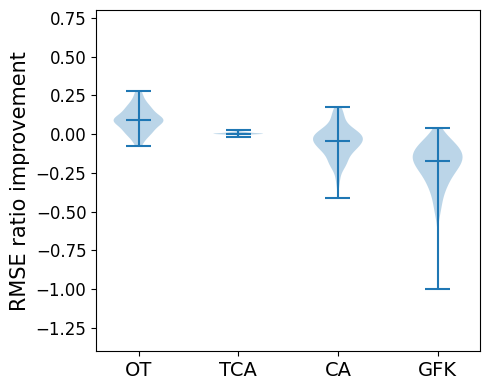

In [30]:
# Overall, for all groups
improve_ratio_combined = []

for group_1 in groups:
    for group_2 in groups:
        if group_1 == group_2:
            continue        
        improve_ratios = ratios_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics)
        improve_ratio_combined.extend(improve_ratios)

trans_metric_dict = {}
for i in range(len(trans_metrics)):
    trans_metric_dict[trans_metrics[i]] = improve_ratio_combined[i]
# print(np.median(trans_metric_dict['GWOT']))
data = pd.DataFrame(trans_metric_dict)
print("medians for each method is:", np.median(data, axis=0))
print(data)


# Plot the dataframe
plt.figure(figsize=[5, 4])
plt.violinplot(data, showmedians=True)
plt.xticks(range(1, len(trans_metrics)+1), labels=trans_metrics)
plt.ylabel(f"{eval_metric} ratio improvement", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax = plt.gca()
ax.set_xticklabels( labels=trans_metrics, fontsize=14)
plt.ylim(-1.4, 0.8)
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{eval_metric}_ratio.pdf")
plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

In [31]:
def print_latex(source, target, ratios, percent):
    """ 
    Print latex for ratios
    """

    print_str = f"{source.title()} & {target.title()}"
    for ratio in ratios:
        if percent:
            print_str += f' & {median(ratio)*100:.1f}({stdev(ratio)*100:.1f})'
        else: 
            base = 10**5
            print_str += f' & {median(ratio)/base:.1f}({stdev(ratio)/base:.1f})'
    print_str += ' \\\ \hline'
    print(print_str)
    

In [32]:
for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if i <= j:
            continue
        # print(f"group 1: {group_1}, group_2: {group_2}")
        # mae_improve_ratios = ratios_for_metrics(group_name, group_1, group_2, 'mae', trans_metrics)
        # print_median_std(mae_improve_ratios, trans_metrics, 'MAE')
        improve_ratios = ratios_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics)
        # print(rmse_improve_ratios)
        # print_median_std(rmse_improve_ratios, trans_metrics, eval_metric)
        print_latex(group_1, group_2, improve_ratios, percent=True)

Divorced & Separated & 15.7(11.7) & 0.6(1.0) & -3.3(12.4) & -36.1(22.0) \\ \hline
Married & Separated & 13.0(12.2) & 0.5(1.1) & -4.7(10.8) & -36.3(22.4) \\ \hline
Married & Divorced & 9.5(11.7) & 0.4(1.0) & -4.0(11.2) & -23.2(27.6) \\ \hline
Widowed & Separated & 19.1(12.7) & 0.5(0.9) & -2.1(10.3) & -54.2(27.3) \\ \hline
Widowed & Divorced & 16.7(12.1) & 0.4(1.0) & -1.3(11.2) & -37.9(31.1) \\ \hline
Widowed & Married & 15.6(9.0) & 0.5(1.0) & -1.4(9.9) & -36.2(18.9) \\ \hline
Single & Separated & 13.6(10.9) & 0.3(0.9) & -3.2(11.5) & -31.1(20.1) \\ \hline
Single & Divorced & 9.0(11.5) & 0.5(1.0) & -2.2(10.1) & -20.3(23.0) \\ \hline
Single & Married & 11.1(10.1) & 0.5(0.9) & -0.9(10.5) & -22.4(17.9) \\ \hline
Single & Widowed & 8.1(10.1) & 0.3(1.0) & -3.2(8.4) & -16.3(20.6) \\ \hline


median is: 10.309527937318926, 11.003235


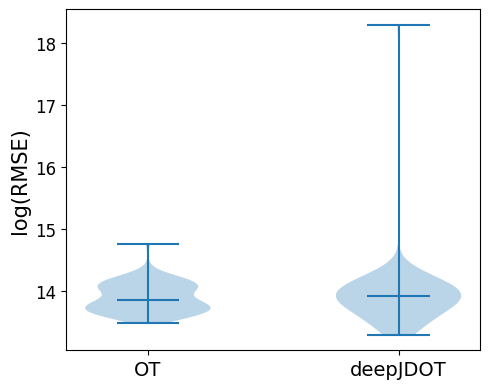

In [33]:
# Present the overall performance for deepJDOT and OTTEHR
trans_metrics = ['OT', 'deepJDOT']
stats_combined = []

for group_1 in groups:
    for group_2 in groups:
        if group_1 == group_2:
            continue        
        stats = stats_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics, filter_na=True)
        stats_combined.extend(stats)

# fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_deepJDOT.pdf")

# plt.tight_layout()
# plt.savefig(fig_path, bbox_inches='tight')
# plt.show()

base = 10**5
print(f"median is: {median(stats_combined[0])/base}, {median(stats_combined[1])/base}")

# Apply log to stats_combined
for i in range(len(stats_combined)):
    stats_combined[i] = [np.log(x) for x in stats_combined[i]]


# Plot the dataframe
plt.figure(figsize=[5, 4])
plt.violinplot([stats_combined[0], stats_combined[1]], showmedians=True)
# plt.violinplot([stats_combined[0], stats_combined[1], stats_combined[2], stats_combined[3], stats_combined[4]], showmedians=True)
plt.xticks(range(1, len(trans_metrics)+1), labels=trans_metrics)
plt.ylabel(f"log({eval_metric})", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax = plt.gca()
ax.set_xticklabels(labels=trans_metrics, fontsize=14)
# plt.ylim(12, 22)
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{eval_metric}_deepJDOT.pdf")
plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

In [34]:
# Calculate the pairwise performance for deepJDOT and OTTEHR


for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if i <= j:
            continue
        stats = stats_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics, filter_na=True)

        print_latex(group_1, group_2, stats, percent=False)

Divorced & Separated & 9.9(3.6) & 8.4(3.0) \\ \hline
Married & Separated & 10.1(2.7) & 8.3(14.1) \\ \hline
Married & Divorced & 9.4(2.2) & 8.4(6.5) \\ \hline
Widowed & Separated & 9.5(2.7) & 7.4(1.7) \\ \hline
Widowed & Divorced & 8.6(3.3) & 7.1(4718.1) \\ \hline
Widowed & Married & 8.6(1.7) & 6.9(4431.5) \\ \hline
Single & Separated & 10.6(2.4) & 9.7(2.4) \\ \hline
Single & Divorced & 10.1(2.6) & 8.9(4183.2) \\ \hline
Single & Married & 10.4(2.9) & 9.8(2025.3) \\ \hline
Single & Widowed & 9.7(2.1) & 9.3(2887.8) \\ \hline


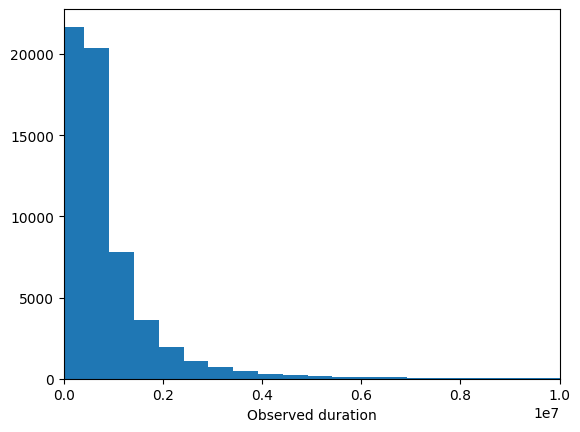

In [35]:
# Plot the distribution of the observed duration in hospital
admid_diagnosis_df = pd.read_csv(os.path.join(mimic_output_dir, "ADMID_DIAGNOSIS.csv"), index_col=0, header=0, converters={'ICD codes': literal_eval})
admid_diagnosis_df['duration']
durations = list(admid_diagnosis_df['duration'])
binwidth = 0.05*10**7
plt.hist(durations, bins=np.arange(min(durations), max(durations) + binwidth, binwidth))
plt.xlim(0, 10**7)
plt.xlabel('Observed duration')
plt.savefig(os.path.join(mimic_output_dir, "observed_duration_distn.pdf"))


In [36]:
# Analyze the precision and recall of the task 
# From the previous plot, we use 1e6 as the threshold 